In this notebook we'll be testing assumption made in our derivation. We investigate the source model visibilities and their impact on the Cramer Rao bound on the gain estimate variances. We also look into how independent the gain solutions for different antennas are. 

### The model signal

If you calculate what the average model signal for a stochastic sky would be the result would be zero for all baselines larger than the fourier transform of the beam. In other words all baselines that probe scale that are a smaller than the beam size (which is more or less all baselines larger than the size of a tile) measure negligible signal.

In reality that is not the case. All baselines measure some signal, the larger baselines do measure less because the signal of all sources combined "decorrelates" faster for longer baselines. But because a real sky is not uniform, there is some assymetry the signals do no completely decorrelate.

In [1]:
import sys
import numpy
import powerbox
from matplotlib import pyplot
sys.path.append("../")

In [2]:
from skymodel import SkyRealisation
from radiotelescope import ideal_gaussian_beam
from generaltools import from_lm_to_theta_phi

In [112]:
def fourier_transform(image, padding_factor = 3):
    padded_sky = numpy.pad(image, padding_factor * image.shape[0], mode="constant")
    shifted_image = numpy.fft.ifftshift(padded_sky, axes=(0, 1))
    visibility_grid, uv_coordinates = powerbox.dft.fft(shifted_image, L=2*(2 * padding_factor + 1), axes=(0, 1))
    return visibility_grid, uv_coordinates
    
    
def visibility_realisation(seed = 0):
    max_lambda = 300
    frequency_channels = 150e6
    padding_factor = 3


    radio_sky = SkyRealisation(sky_type="random", seed=seed, flux_low = 1)
    radio_image, l_coordinates = radio_sky.create_sky_image(frequency_channels = frequency_channels, 
                                                        resolution = 1/max_lambda)
    ll, mm = numpy.meshgrid(l_coordinates, l_coordinates)
    tt, pp = from_lm_to_theta_phi(ll, mm)

    beam_response = ideal_gaussian_beam(ll, mm, frequency_channels)
    apparent_sky = radio_image * beam_response

    visibility_grid, uv_coordinates = fourier_transform(apparent_sky)
    
    return visibility_grid, uv_coordinates

figure = pyplot.figure(figsize = (18,5))
sky_axes = figure.add_subplot(131)
beam_axes = figure.add_subplot(132)
obs_axes = figure.add_subplot(133)

sky_axes.imshow(radio_image)
beam_axes.imshow(beam_response)
obs_axes.imshow(apparent_sky)
pyplot.show()

figure = pyplot.figure(figsize = (5*4+3,5))
real_axes = figure.add_subplot(141)
imag_axes = figure.add_subplot(142)
amp_axes = figure.add_subplot(143)
phase_axes = figure.add_subplot(144)

real_axes.imshow(numpy.real(visibility_grid))
imag_axes.imshow(numpy.imag(visibility_grid))
amp_axes.imshow(numpy.abs(visibility_grid))
phase_axes.imshow(numpy.angle(visibility_grid))

pyplot.show()

In [113]:
n_realisations = 100


for i in range(n_realisations):
    visibility_grid, uv_coordinates =  visibility_realisation(seed = i )
    index = int(visibility_grid.shape[0]/2)
    
    if i == 0:
        realised_vis = numpy.zeros(visibility_grid[index, :].shape + (n_realisations,), dtype = complex)
        averaged_vis = visibility_grid[index, :]
    else: 
        averaged_vis += visibility_grid[index, :]
    
    realised_vis[:,i] = visibility_grid[index, :]

averaged_vis /= n_realisations

../generaltools.py:51: RuntimeWarning: invalid value encountered in arcsin
  theta = numpy.arcsin(numpy.sqrt(ll ** 2. + mm ** 2.))
../generaltools.py:52: RuntimeWarning: divide by zero encountered in true_divide
  phi = numpy.arctan(mm / ll)
../generaltools.py:52: RuntimeWarning: invalid value encountered in arctan
  phi = numpy.arctan(mm / ll)


In [48]:
l_coordinates = numpy.linspace(-1,1,100)
ll, mm = numpy.meshgrid(l_coordinates, l_coordinates)

beam_response = ideal_gaussian_beam(ll, mm, frequency_channels)

fourier_beam, uv_beam = fourier_transform(beam_response)

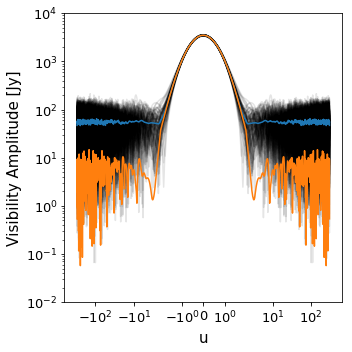

In [132]:
index = int(fourier_beam.shape[0]/2)

labelfontsize = 15
tickfontsize = 13
figure = pyplot.figure(figsize = (5, 5))

realised_axes = figure.add_subplot(111)
realised_axes.plot(uv_coordinates[0, :], numpy.abs(realised_vis), 'k', alpha = 0.1)
#realised_axes.plot(uv_beam[0, :], numpy.abs(fourier_beam[index, :])*1.5*1e4, 'k',linewidth = 2)
realised_axes.plot(uv_coordinates[0, :], numpy.sum(numpy.abs(realised_vis), axis = 1)/n_realisations)
realised_axes.plot(uv_coordinates[0, :], numpy.abs(averaged_vis))

realised_axes.set_xlabel('u', fontsize = labelfontsize )
realised_axes.set_ylabel('Visibility Amplitude [Jy]', fontsize = labelfontsize)

realised_axes.tick_params(axis='both', which='major', labelsize=tickfontsize)
realised_axes.set_xscale('symlog')
realised_axes.set_yscale('log')
realised_axes.set_ylim(1e-2,1e4)
figure.tight_layout()

#averaged_axes = figure.add_subplot(122)
#averaged_axes.plot(uv_coordinates[0, :], numpy.abs(averaged_vis))
#averaged_axes.plot(uv_coordinates[0, :], numpy.sum(numpy.abs(realised_vis), axis = 1)/n_realisations, '--')
#averaged_axes.plot(uv_beam[0, :], numpy.abs(fourier_beam[index, :])*1.5*1e4, 'k',linewidth = 5, alpha=0.3)


#averaged_axes.set_xscale('symlog')
#averaged_axes.set_yscale('log')    



#averaged_axes.set_ylim(1e-2,1e4)    


#averaged_axes.set_xlabel('u', fontsize = labelfontsize)

#averaged_axes.tick_params(axis='both', which='major', labelsize=tickfontsize)

figure.savefig("../../../Plots/Analytic_Covariance/Mean_Visibility_Amplitudes.png")

pyplot.show()

### The Fisher Information Matrix

Considering that all baselines do measure some amount of signal with some variance which we can describe. What does that imply for our FIM? Is it really different for different tiles? What happens to the tiles in that participate in the EoR range. We would expect the variance of a tile gain to depend on its location in the array. 

Considering that "core" tiles participate in a wide range of baselines, similarly for the "hex" tiles, but less so for the outer tiles. We expect that core/hex tiles have better constrains on their gain solutions. We will compute the full Fisher Information Matrix, and also look at the inverse to see how the variance depends on tile location and how strong the correlation of variances are between different tiles.

In [133]:
import sys
import numpy
import powerbox
from matplotlib import pyplot
sys.path.append("../")